## Nombre: Laura Fierro
## Fecha clase: 20-07-2020

# Descripción
Para esta sesión trabajaremos con la base de datos sobre cáncer mamario de Wisconsin. El objetivo es desarrollar un Clasificador mediante Máquinas de Soporte de Vectores que predica de forma adecuada en base a una serie de atributos sobre la composición del núcleo de una célula mamaria. Para más detalles técnicos asociados a la base de datos, revisar el archivo `wdbc.names`.

# Ejercicio 1: Preparar el ambiente de trabajo
- Importe todas las librerías a utilizar.
- Fije los parámetros de los gráficos con `plt.Rcparams`.
- Excluya las columnas `id` y `Unnamed: 32` de la base de datos.
- Recodifique el vector objetivo diagnosis a numérico para poder procesarlo posteriormente.

In [77]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

warnings.simplefilter('ignore')
# plt.rcParams['figure.figsize']=(20,40)
plt.style.use('seaborn')

df=pd.read_csv('breast_cancer.csv').drop(columns=['id', 'Unnamed: 32'])

In [78]:
df['diagnosis_bin']=LabelBinarizer().fit_transform(df['diagnosis'])
df.sample()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis_bin
228,B,12.62,23.97,81.35,496.4,0.07903,0.07529,0.05438,0.02036,0.1514,...,31.31,90.67,624.0,0.1227,0.3454,0.3911,0.118,0.2826,0.09585,0


# Ejercicio 2: Visualizando la distribución de los atributos
- Para cada uno de los atributos, grafique los histogramas condicional a cada clase del vector objetivo.
- Agregue las medias correspondientes y reporte a grandes rasgos cuáles son los atributos con una mayor similitud en la distribución.

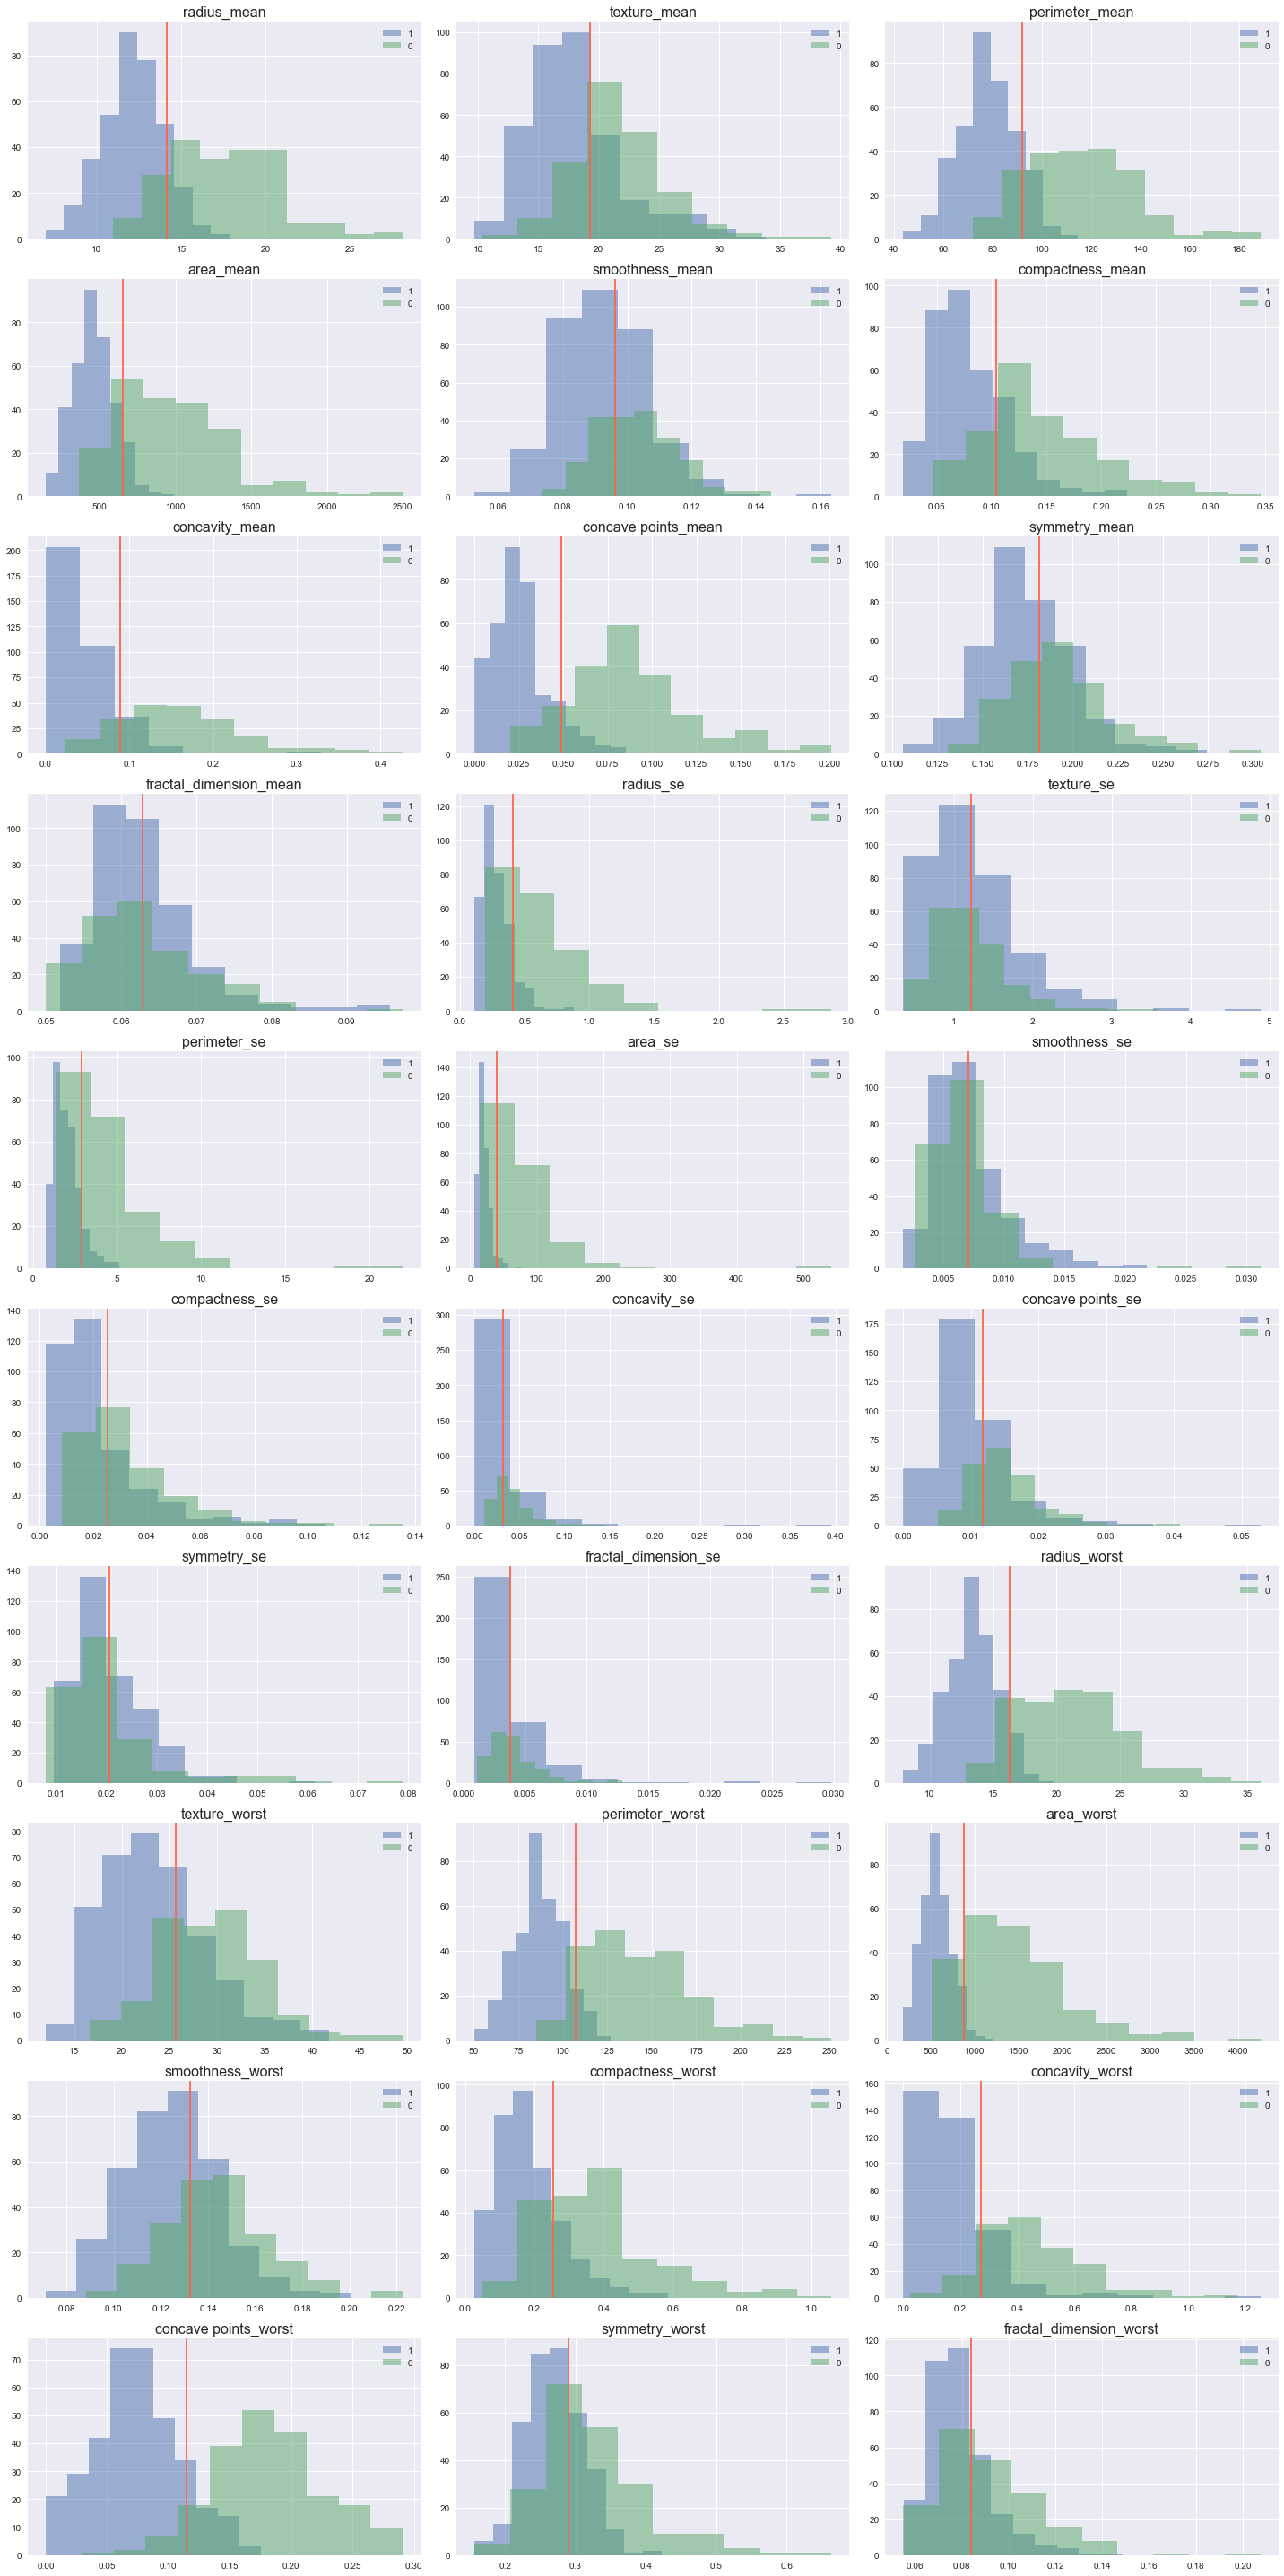

In [79]:
plt.figure(figsize=(20,40))
for index,(colname,serie) in enumerate(df.loc[:,'radius_mean':'fractal_dimension_worst'].iteritems()):
    plt.subplot(10,3,index+1)
    if pd.api.types.is_float_dtype(serie) is True:
        df.groupby('diagnosis_bin')[colname].plot(kind='hist',alpha=.5)
    elif pd.api.types.is_integer_dtype(serie) is True:
        df.groupby('diagnosis_bin')[colname].plot(kind='bar',alpha=.5)
    plt.legend(df['diagnosis_bin'].unique())
    plt.axvline(np.mean(serie),color='tomato',label='media')
    plt.title(colname,fontsize=16)
    plt.xlabel(''); plt.ylabel(''); plt.tight_layout()

De los gráficos, podemos ver que las cariables *concave points_mean*, *concavity_mean*, *perimeter_worst*, *concavity_worst* y *concave points_worst*, presentan una separación más marcada entre clases que las demás, lo que podría facilitar la generación de una recta que divida ambas clases en las ellas. Por el contrario, las variables *smothness_mean*, *symmetry_mean*, *fractal_dimension_mean*, *texture_se*, *concavity_se*, *concave points_se*, *symmetry_se*, *fractal_dimension_se*, *smothness_worst*, *symmetry_worst* y *fractal_dimension_worst* poseen distribuciones similares en ambas clases, lo que dificultará el encontrar una recta que separe ambas clases.

# Ejercicio 3: Estimando el porcentaje de overlap en los atributos
- Parte de las virtudes de las Máquinas de Soporte Vectorial es la capacidad de lidiar con clases no separables mediante el proceso de kernelización. Resulta que un aspecto importante que muchas veces se obvía es medir la noseparabilidad de los atributos, condicional a cada clase del vector objetivo.
- El procedimiento para estimar el rango de noseparabilidad entre clases se implementa en Python de la siguiente manera:
```python
def histogram_overlap(df, attribute, target, perc=100):
    # get lower bound
    empirical_lower_bound = np.floor(df[attribute].min())
    # get upper bound
    empirical_upper_bound = np.ceil(df[attribute].max())
    # preserve histograms
    tmp_hist_holder = dict()

    # for each target class
    for unique_value in np.unique(df[target]):
        # get histogram
        tmp, _ = np.histogram(
            # for a specific attribute
            df[df[target] == unique_value][attribute],
            # define percentage
            bins=perc,
            # limit empirical range for comparison
            range=[empirical_lower_bound, empirical_upper_bound]
        )
        # append to dict
        tmp_hist_holder["h_"+str(unique_value)] = tmp

    get_minima = np.minimum(tmp_hist_holder["h_1"], tmp_hist_holder["h_-1"])
    intersection = np.true_divide(np.sum(get_minima),np.sum(tmp_hist_holder["h_-1"]))
return intersection
```
- La intersección devolverá el porcentaje de comunalidad entre ambas clases, donde mayores niveles indican una mayor comunalidad.
- Utilizando la función, genere un dataframe donde almacenará el nombre del atributo y su porcentaje. Ordene este dataframe de forma descendente y preserve.

In [80]:
def histogram_overlap(df, attribute, target, perc=100):
    # get lower bound
    empirical_lower_bound = np.floor(df[attribute].min())
    # get upper bound
    empirical_upper_bound = np.ceil(df[attribute].max())
    # preserve histograms
    tmp_hist_holder = dict()
    # for each target class
    for unique_value in np.unique(df[target]):
        # get histogram
        tmp, _ = np.histogram(
        # for a specific attribute
        df[df[target] == unique_value][attribute],
        # define percentage
        bins=perc,
        # limit empirical range for comparison
        range=[empirical_lower_bound, empirical_upper_bound]
        )
    # append to dict
        tmp_hist_holder["h_"+str(unique_value)] = tmp
    get_minima = np.minimum(tmp_hist_holder["h_1"], tmp_hist_holder["h_0"])
    intersection = np.true_divide(np.sum(get_minima), np.sum(tmp_hist_holder["h_0"]))
    return intersection

In [81]:
attribute=[]
overlap=[]

for colname,serie in df.loc[:,'radius_mean':'fractal_dimension_worst'].iteritems():
    attribute.append(colname)
    overlap.append(histogram_overlap(df,colname,'diagnosis_bin'))

Overlap_Diagnosis=pd.DataFrame({'Attribute':attribute,'Overlap':overlap}).sort_values(by='Overlap',ascending=False)
Overlap_Diagnosis

,Attribute,Overlap
19,fractal_dimension_se,0.593838
14,smoothness_se,0.591036
9,fractal_dimension_mean,0.588235
18,symmetry_se,0.568627
11,texture_se,0.549020
15,compactness_se,0.523810
4,smoothness_mean,0.521008
8,symmetry_mean,0.509804
17,concave points_se,0.507003
29,fractal_dimension_worst,0.492997


# Ejercicio 4: Selección del modelo por GridSearchCV
- Entrene una serie de modelos `SVC` con los siguientes hiperparámetros:
    - `C: [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]`.
    - `gamma: [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]`.
    - Validaciones cruzadas: 10.
- Genere un heatmap en base a los puntajes estimados con GridSearchCV .
*tip*: Vea cómo acceder a la llave `mean_test_score` en el diccionario `cv_results_`.

>**Digresión: Un par de elementos a considerar en la implementación de `GridSearchCV`**
Si trabajamos con `sklearn.model_selection.GridSearchCV`, tan solo haciendo la división en dos muestras es suficiente, incorporando los conjuntos `X_train` y `y_train` a nuestro objeto instanciado y preservando `X_test` e `y_test` como una muestra de validación externa. Si tenemos un archivo de testing externo, se recomienda no hacer división.
- El objeto creado con `sklearn.model_selection.GridSearchCV` sigue la misma funcionalidad de cualquier método de estimación de `scikit-learn`, con los pasos de Instanciar y Entrenar. Este objeto tendrá muchos elementos a considerar:
    - `sklearn.model_selection.GridSearchCV.cv_results_` devolverá un diccionario donde las llaves representarán distintas métricas y los valores representarán el desempeño de cada modelo:
        - `split*` Indicará la métrica específica en cada validacieon cruzada y combinación de hiperparámetros.
        - `*_time` Indicará el tiempo de ejecución en cada modelo.
    - Por lo general trabajaremos con `mean_test_score` y `mean_train_score` que representa la media de CV para cada combinación de hiperparámetros.
    - `sklearn.model_selection.GridSearchCV.best_estimator_` devuelve un modelo listo para entrenar con la mejor combinación de hiperparámetros.
    - `sklearn.model_selection.GridSearchCV.best_score_` devuelve el desempeño promedio del modelo en el testing interno. Si es un problema de clasificación devolverá `Accuracy` , si es un problema de regresión devolverá `MSE`.
        
- Reporte en qué rango de cada hiperparámetro el modelo presenta un desempeño eficiente. Reporte la mejor combinación de hiperparámetros y el desempeño en la muestra de entrenamiento.

In [92]:
X_pre,X_HO,y_pre,y_HO=train_test_split(df.loc[:,'radius_mean':'fractal_dimension_worst'],
                                               df['diagnosis_bin'],
                                               test_size=.30,random_state=17127)

X_train,X_test,y_train,y_test=train_test_split(X_pre,y_pre,
                                               test_size=.30,random_state=17127)

SC=StandardScaler()
X_train_std=SC.fit_transform(X_train)
X_test_std=SC.transform(X_test)

params={'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
       'gamma': [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}

In [93]:
estimateCV=GridSearchCV(SVC(kernel='rbf'),params,cv=10)
estimateCV.fit(X_train_std,y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [1e-07, 0.0001, 0.001, 0.01, 0.1, 1, 10]})

In [94]:
cv_params=estimateCV.cv_results_['mean_test_score'].reshape(8,7)

Text(0.5, 1.0, 'Accuracy Heatmap')

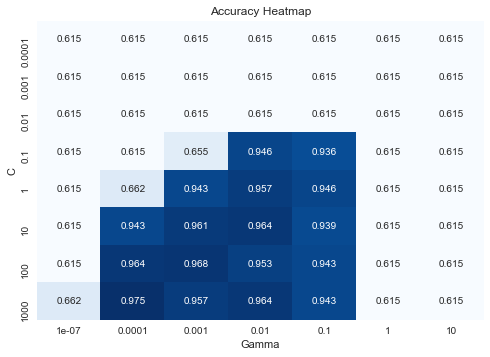

In [95]:
sns.heatmap(cv_params,annot=True,cmap='Blues',cbar=False,fmt='.3',
            xticklabels=[0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
            yticklabels=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000])
plt.xlabel('Gamma')
plt.ylabel('C')
plt.title('Accuracy Heatmap')

In [96]:
print('Mejor combinación: {}'.format(estimateCV.best_params_))
print('Accuracy: {}'.format(estimateCV.best_score_.round(3)))

Mejor combinación: {'C': 1000, 'gamma': 0.0001}
Accuracy: 0.975


# Ejercicio 5: Validación del modelo en el hold-out sample
- Genere las predicciones del hold-out sample en base a la mejor combinación de hiperparámetros. Genere un reporte con las métricas de desempeño clásicas para los modelos de clasificación. Comente en qué casos el modelo presenta un desempeño deficiente.

In [97]:
X_HO_std=SC.transform(X_HO)

print(classification_report(y_HO,estimateCV.best_estimator_.predict(X_HO_std)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       104
           1       1.00      0.93      0.96        67

    accuracy                           0.97       171
   macro avg       0.98      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171



Observando las métricas, la detección de cáncer (clase 1), es ligeramente menor su f1-score, pese a ser la clase que necesitamos predecir. Sin embargo, sigue siendo un buen desempeño para el modelo, con un valor de 0.96. El valor de accuracy essimilar a los obtenidos en la validación de los hiperparámetros.

# Ejercicio (opcional): Depuración de atributos
- Reentrene el modelo en función de los atributos que presenten un coeficiente de overlap menor a .45.
- Reporte el desempeño del modelo y comente sobre los nuevos hiperparámetros estimados, así como su desempeño en comparación al modelo del ejercicio 5.

In [98]:
X_train2,X_test2,y_train2,y_test2=train_test_split(df.loc[:,Overlap_Diagnosis[Overlap_Diagnosis['Overlap']<0.45].Attribute],
                                               df['diagnosis_bin'], test_size=.30, random_state=17127)

SC2=StandardScaler()
X_train_std2=SC2.fit_transform(X_train2)
X_test_std2=SC2.transform(X_test2)

params={'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
       'gamma': [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}

In [99]:
estimateCV2=GridSearchCV(SVC(kernel='rbf'),params,cv=10)
estimateCV2.fit(X_train_std2,y_train2)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [1e-07, 0.0001, 0.001, 0.01, 0.1, 1, 10]})

In [100]:
print('Mejor combinación: {}'.format(estimateCV2.best_params_))
print('Accuracy: {}'.format(estimateCV2.best_score_.round(3)))

Mejor combinación: {'C': 1000, 'gamma': 0.001}
Accuracy: 0.977


In [101]:
print(classification_report(y_test2,estimateCV2.best_estimator_.predict(X_test_std2)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       104
           1       1.00      0.94      0.97        67

    accuracy                           0.98       171
   macro avg       0.98      0.97      0.98       171
weighted avg       0.98      0.98      0.98       171



Comparado con los modelos anteriores, tiene una mejora de 1 punto porcentual en la clasificación de la clase 1, lo mismo con el accuracy del modelo.